        Open        High        Low      Close  Volume   Returns
0  99.929141  100.080275  99.849591  99.932658    7420 -0.000709
1  99.794540   99.979029  99.621221  99.769512    9802 -0.001348
2  99.982663  100.007435  99.898296  99.975004    1913  0.001883
3  99.676353   99.866775  99.512329  99.670978    1802 -0.003068
4  99.852406  100.036588  99.608119  99.731547    5937  0.001765


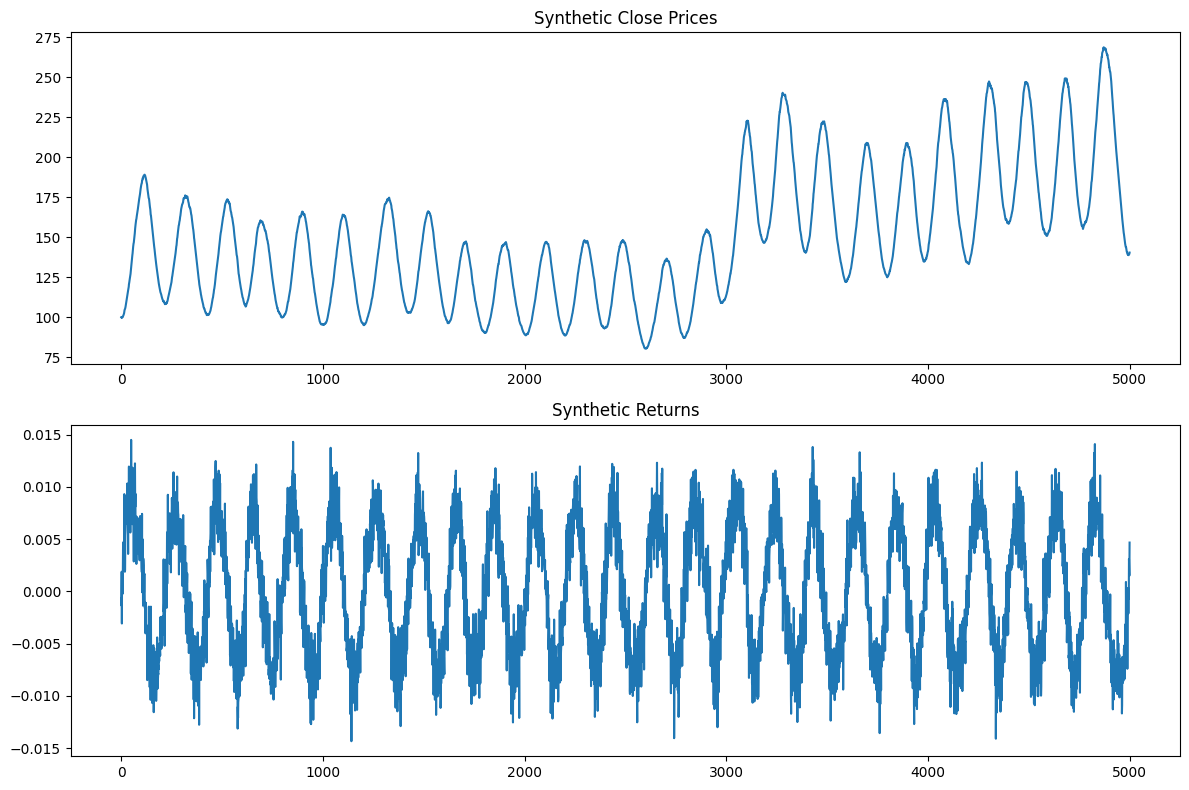

In [8]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization

def generate_synthetic_market_data(
    n_steps=1000,
    base_volatility=0.01,
    signal_strength=0.8,
    noise_strength=0.2,
    freq_range=(0.0001, 0.01),
    freq_noise_scale=0.5,
    random_seed=None
):
    """
    Generate synthetic OHLCV + Returns data.
    
    Args:
        n_steps (int): Number of timesteps.
        base_volatility (float): Base volatility of returns.
        signal_strength (float): Scale of structured signal.
        noise_strength (float): Scale of noise added.
        freq_range (tuple): Min/max frequency for oscillations.
        random_seed (int): Random seed for reproducibility.
        
    Returns:
        pd.DataFrame: Dataframe with Open, High, Low, Close, Volume, Returns
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Time array
    t = np.linspace(0, 1, n_steps)

    # Oscillatory signal with varying frequency
    freq = np.linspace(freq_range[0], freq_range[1], n_steps)

    # Normalize structured returns
    if freq_noise_scale > 0:
        freq += np.random.normal(0, freq_noise_scale, size=n_steps)
        freq = np.clip(freq, freq_range[0], freq_range[1])
    
    phase = np.cumsum(freq) * 2 * np.pi
    structured_returns = np.sin(phase)

    # Add noise
    noise = np.random.normal(0, 1, n_steps)

    returns = signal_strength * structured_returns + noise_strength * noise

    # Scale to base volatility
    returns = returns * base_volatility

    # Create price series from returns
    price = 100 * np.exp(np.cumsum(returns))

    # Generate OHLCV
    open_prices = price
    close_prices = price * (1 + np.random.normal(0, 0.0005, n_steps))
    high_prices = np.maximum(open_prices, close_prices) * (1 + np.random.uniform(0.0001, 0.002, n_steps))
    low_prices = np.minimum(open_prices, close_prices) * (1 - np.random.uniform(0.0001, 0.002, n_steps))
    volumes = np.random.randint(100, 10000, size=n_steps)

    # Build DataFrame
    df = pd.DataFrame({
        'Open': open_prices,
        'High': high_prices,
        'Low': low_prices,
        'Close': close_prices,
        'Volume': volumes,
        'Returns': returns
    })

    return df

# Example usage
df = generate_synthetic_market_data(
    n_steps=5000
)

print(df.head())

# Plot to visualize (optional)
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2, 1, figsize=(12,8))
    axs[0].plot(df['Close'])
    axs[0].set_title('Synthetic Close Prices')
    axs[1].plot(df['Returns'])
    axs[1].set_title('Synthetic Returns')
    plt.tight_layout()
    plt.savefig('trials-synthetic-slight-noise/synthetic-slight-noise.png')
    plt.show()

In [9]:
df.drop(columns=['Returns'], inplace=True)
df = data.train_test_split(df)
df = data.add_returns(df)
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,SPLIT,Return,Return_Target
0,99.929141,100.080275,99.849591,99.932658,7420,train,-0.001347,0.001885
1,99.794540,99.979029,99.621221,99.769512,9802,train,0.001885,-0.003064
2,99.982663,100.007435,99.898296,99.975004,1913,train,-0.003064,0.001766
3,99.676353,99.866775,99.512329,99.670978,1802,train,0.001766,0.000658
4,99.852406,100.036588,99.608119,99.731547,5937,train,0.000658,0.001210


In [10]:
# normalize all features but not targets
DF = df.copy()

numerical_columns = categorical_columns = "all"
exclude_columns = [] # ['Return_Target']
DF_features = ['Open', 'High', 'Low', 'Close', 'Volume']
DF, DF_columns = data.normalize_data(DF, exclude_columns=exclude_columns)

In [11]:
DF

,Open,High,Low,Close,Volume,SPLIT,Return,Return_Target
0,0.104221,0.104234,0.104133,0.104270,0.739693,train,0.446788,0.558944
1,0.103507,0.103698,0.102921,0.103404,0.980396,train,0.558944,0.387217
2,0.104505,0.103848,0.104392,0.104495,0.183205,train,0.387217,0.554819
3,0.102881,0.103102,0.102344,0.102882,0.171989,train,0.554819,0.516366
4,0.103814,0.104003,0.102852,0.103203,0.589834,train,0.516366,0.535510
...,...,...,...,...,...,...,...,...
4993,0.310854,0.311013,0.311134,0.310971,0.140966,test,0.499687,0.468485
4994,0.310985,0.311553,0.309783,0.310514,0.121766,test,0.468485,0.601278
4995,0.310453,0.311528,0.309788,0.311275,0.386520,test,0.601278,0.568714
4996,0.312739,0.312058,0.312517,0.312708,0.420776,test,0.568714,0.545748


In [ ]:
import json
import optuna
from IPython.display import display, HTML
import joblib

importlib.reload(LSTM_returns)

Log = []

def objective(trial):
    entry = {}
    # Example of hyperparameter suggestions
    hyperparams = {
        'lstm_units': 70,
        'num_layers': trial.suggest_int('num_layers', 3, 5), # 1 to 5
        'epochs': 20,
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'dropout': 0.05,
        # 'dropout': trial.suggest_float('dropout_rate', 0.0, 0.5),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]),
        # 'LSTM_activation': trial.suggest_categorical('lstm_activation', ['relu', 'tanh']),
        # 'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'activation': 'tanh',
        '__+ABD_exceptLast': trial.suggest_categorical('__+ABD_exceptLast', [True, False]),
        '__finalAct': trial.suggest_categorical('__finalAct', ['linear', 'sigmoid', 'tanh']),
        # '__penultRelu': trial.suggest_categorical('__penultRelu', [True, False]),
        'optimizer': 'adam',
        # 'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop']),
        # 'loss': trial.suggest_categorical('loss', ['mean_squared_error', 'mean_absolute_error', 'huber']),
    }
    episode_lengths = trial.suggest_int('episode_length', 10, 40)
    hyperparams['episode_length'] = episode_lengths
    hyperparams['layers'] = [hyperparams['lstm_units']] * hyperparams['num_layers']
    hyperparams['loss'] = 'mean_squared_error'
    

    train_X_y = LSTM_returns.vectorize_train_data(DF, features=DF_features, episode_length=episode_lengths)
    hyperparams['input_shape'] = train_X_y['train_X'].shape[1:]
    
    LSTM = LSTM_returns.create(hyperparams)
    results = LSTM_returns.train(LSTM, hyperparams, train_X_y, evaluateAtEnd=False)

    entry['hyperparams'] = hyperparams
    entry['results'] = results
    entry['plot-title'] = f"EL: {episode_lengths}; HP: {json.dumps(hyperparams)}"
    entry['model'] = LSTM
    entry['train_X_y'] = train_X_y
    Log.append(entry)

    return results.history['loss'][-1]  # Return the last loss value as the score


# Example Optuna study
study = optuna.create_study(direction='minimize')  # or 'maximize' depending on the objective


for i in range(50):
    study.optimize(objective, n_trials=1)

    # best_entry = [
    #     entry for entry in Log if entry['results'].history['loss'][-1] == study.best_value
    # ][-1]

    latest_entry = Log[-1]
    Log = []

    # Print the best hyperparameters
    # Display the best hyperparameters and score in purple
    display(HTML(f"""
    <div style="color: purple; background: orange; font-weight: bold;">
        Trial {i*10+1} completed.<br>
        Best hyperparameters: {study.best_params}<br>
        Best score (MSE): {study.best_value}<br>
    </div>
    """))

    # Display the best entry plot
    plt = LSTM_returns.all_folds_plot(
        latest_entry['model'], latest_entry['train_X_y']
    )
    plt.title(latest_entry['plot-title'][:175])
    print(latest_entry['plot-title'])
    plt.savefig(f"trials-synthetic-slight-noise/{i*10:05}.png", dpi=150, bbox_inches='tight')
    plt.close()


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-26 21:05:33,436] A new study created in memory with name: no-name-2ad2e3d0-36cf-41d3-bdb4-889f5fab4c86


Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0663 - mae: 0.1854
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0209 - mae: 0.1146
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135 - mae: 0.0927
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132 - mae: 0.0913
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0141 - mae: 0.0940
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - mae: 0.0835
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - mae: 0.0788
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0094 - mae: 0.0772
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - mae: 0.0766
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089 - mae: 0.0751
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093 - mae: 0.0770
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0090 - mae: 0.0751
Epoch 13/20
250/250 ━━━━━━━━━━━━━━━━

[I 2025-04-26 21:06:04,709] Trial 0 finished with value: 0.008105072192847729 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.01, '__+ABD_exceptLast': True, '__finalAct': 'linear', 'episode_length': 13}. Best is trial 0 with value: 0.008105072192847729.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 13; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "linear", "optimizer": "adam", "episode_length": 13, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [13, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1045 - mae: 0.2366
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0290 - mae: 0.1375
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0202 - mae: 0.1128
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0158 - mae: 0.0996
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0112 - mae: 0.0842
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0106 - mae: 0.0820
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0098 - mae: 0.0784
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0102 - mae: 0.0788
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0102 - mae: 0.0799
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0119 - mae: 0.0864
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0102 - mae: 0.0793
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0092 - mae: 0.0762
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/s

[I 2025-04-26 21:06:30,047] Trial 1 finished with value: 0.007823447696864605 and parameters: {'num_layers': 5, 'batch_size': 64, 'learning_rate': 0.1, '__+ABD_exceptLast': True, '__finalAct': 'tanh', 'episode_length': 14}. Best is trial 1 with value: 0.007823447696864605.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 14; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 14, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [14, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0898 - mae: 0.2443
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0429 - mae: 0.1800
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0392 - mae: 0.1703
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0277 - mae: 0.1380
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0158 - mae: 0.1021
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0111 - mae: 0.0847
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0084 - mae: 0.0737
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - mae: 0.0754
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0731
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - mae: 0.0735
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0100 - mae: 0.0800
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - mae: 0.0692
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - lo

[I 2025-04-26 21:06:46,159] Trial 2 finished with value: 0.007081623189151287 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'episode_length': 17}. Best is trial 2 with value: 0.007081623189151287.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 17; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 17, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [17, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0476 - mae: 0.1688
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0098 - mae: 0.0796
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0095 - mae: 0.0780
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0078 - mae: 0.0711
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0077 - mae: 0.0696
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0075 - mae: 0.0699
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0076 - mae: 0.0691
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0068 - mae: 0.0653
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0074 - mae: 0.0683
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0066 - mae: 0.0645
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0081 - mae: 0.0705
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0067 - mae: 0.0645
Epoch 13/20
248/248 ━━━━

[I 2025-04-26 21:07:45,741] Trial 3 finished with value: 0.006917959079146385 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'episode_length': 40}. Best is trial 3 with value: 0.006917959079146385.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 40, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0613 - mae: 0.1801
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0148 - mae: 0.0972
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0113 - mae: 0.0840
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0113 - mae: 0.0843
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0099 - mae: 0.0787
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0091 - mae: 0.0760
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0106 - mae: 0.0816
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0090 - mae: 0.0754
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0089 - mae: 0.0749
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0083 - mae: 0.0715
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0083 - mae: 0.0716
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0080 - mae: 0.0710
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/s

[I 2025-04-26 21:08:13,097] Trial 4 finished with value: 0.008587238378822803 and parameters: {'num_layers': 4, 'batch_size': 64, 'learning_rate': 0.001, '__+ABD_exceptLast': True, '__finalAct': 'tanh', 'episode_length': 19}. Best is trial 3 with value: 0.006917959079146385.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 19; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 19, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [19, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0518 - mae: 0.1863
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0120 - mae: 0.0882
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0091 - mae: 0.0767
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0085 - mae: 0.0730
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0722
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0078 - mae: 0.0709
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0082 - mae: 0.0718
Epoch 8/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0075 - mae: 0.0691
Epoch 9/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0078 - mae: 0.0700
Epoch 10/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0075 - mae: 0.0691
Epoch 11/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0076 - mae: 0.0698
Epoch 12/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0072 - mae: 0.0677
Epoch 13/20
249/249 ━━━━━━━━━━━━━━━━

[I 2025-04-26 21:08:53,813] Trial 5 finished with value: 0.007160651963204145 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'episode_length': 24}. Best is trial 3 with value: 0.006917959079146385.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 24; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 24, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [24, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0258 - mae: 0.1285
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - mae: 0.0825
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - mae: 0.0814
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - mae: 0.0806
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0752
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0723
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0699
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0714
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0738
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0707
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0707
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0716
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━

[I 2025-04-26 21:09:18,226] Trial 6 finished with value: 0.007509926799684763 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.01, '__+ABD_exceptLast': True, '__finalAct': 'sigmoid', 'episode_length': 17}. Best is trial 3 with value: 0.006917959079146385.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 17; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 17, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [17, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0611 - mae: 0.2065
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0431 - mae: 0.1805
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0429 - mae: 0.1788
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0340 - mae: 0.1555
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135 - mae: 0.0927
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0099 - mae: 0.0796
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0086 - mae: 0.0739
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - mae: 0.0698
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0088 - mae: 0.0745
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0079 - mae: 0.0707
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - mae: 0.0696
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0078 - mae: 0.0706
Epoch 13/20
250/250 ━━━━━━━━━━━━━━━━

[I 2025-04-26 21:09:51,000] Trial 7 finished with value: 0.007379224523901939 and parameters: {'num_layers': 4, 'batch_size': 16, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'episode_length': 12}. Best is trial 3 with value: 0.006917959079146385.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
EL: 12; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 12, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [12, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0676 - mae: 0.1990
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0204 - mae: 0.1123
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0136 - mae: 0.0919
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0131 - mae: 0.0910
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0118 - mae: 0.0852
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0105 - mae: 0.0814
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0104 - mae: 0.0804
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0107 - mae: 0.0811
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0095 - mae: 0.0767
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0102 - mae: 0.0804
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0102 - mae: 0.0795
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0094 - mae: 0.0766
Epoch 13/20
250/250 ━━━━━━

[I 2025-04-26 21:10:53,737] Trial 8 finished with value: 0.008819806389510632 and parameters: {'num_layers': 5, 'batch_size': 16, 'learning_rate': 0.01, '__+ABD_exceptLast': True, '__finalAct': 'linear', 'episode_length': 14}. Best is trial 3 with value: 0.006917959079146385.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 14; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "linear", "optimizer": "adam", "episode_length": 14, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [14, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0357 - mae: 0.1582
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0119 - mae: 0.0873
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0086 - mae: 0.0735
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0084 - mae: 0.0732
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0071 - mae: 0.0665
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0071 - mae: 0.0668
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0069 - mae: 0.0657
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0066 - mae: 0.0644
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0067 - mae: 0.0652
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0065 - mae: 0.0648
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0069 - mae: 0.0660
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0065 - mae: 0.0643
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:11:31,404] Trial 9 finished with value: 0.006168483756482601 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 37}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 37; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 37, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [37, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0347 - mae: 0.1558
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0124 - mae: 0.0885
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0085 - mae: 0.0732
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0078 - mae: 0.0693
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0072 - mae: 0.0672
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0075 - mae: 0.0683
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0073 - mae: 0.0681
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0069 - mae: 0.0662
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0066 - mae: 0.0645
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0069 - mae: 0.0657
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0076 - mae: 0.0691
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0074 - mae: 0.0687
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:12:20,827] Trial 10 finished with value: 0.00641333032399416 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 37}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 37; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 37, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [37, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0329 - mae: 0.1519
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0109 - mae: 0.0819
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0094 - mae: 0.0774
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0071 - mae: 0.0670
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0073 - mae: 0.0678
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0072 - mae: 0.0677
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0071 - mae: 0.0667
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0067 - mae: 0.0656
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0076 - mae: 0.0693
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0069 - mae: 0.0656
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0067 - mae: 0.0657
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0070 - mae: 0.0665
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:13:11,720] Trial 11 finished with value: 0.006655597593635321 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 38}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 38; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 38, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [38, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0330 - mae: 0.1518
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0125 - mae: 0.0888
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0088 - mae: 0.0752
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0076 - mae: 0.0697
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0076 - mae: 0.0691
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0077 - mae: 0.0695
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0070 - mae: 0.0664
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0073 - mae: 0.0674
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0070 - mae: 0.0663
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0074 - mae: 0.0687
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0068 - mae: 0.0656
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0072 - mae: 0.0678
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:13:48,490] Trial 12 finished with value: 0.006641908083111048 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 33}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
EL: 33; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 33, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [33, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0347 - mae: 0.1558
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0118 - mae: 0.0851
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0107 - mae: 0.0813
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0082 - mae: 0.0720
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0085 - mae: 0.0726
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0084 - mae: 0.0722
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0074 - mae: 0.0683
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0090 - mae: 0.0752
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0079 - mae: 0.0705
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0069 - mae: 0.0659
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0066 - mae: 0.0646
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0068 - mae: 0.0649
Epoch 13/20
125/125 ━━━━

[I 2025-04-26 21:14:33,192] Trial 13 finished with value: 0.006561869289726019 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.0001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 32}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 32; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.0001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 32, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [32, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0343 - mae: 0.1559
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0135 - mae: 0.0921
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0093 - mae: 0.0766
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0081 - mae: 0.0718
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0079 - mae: 0.0706
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0080 - mae: 0.0709
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0074 - mae: 0.0681
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0069 - mae: 0.0655
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0064 - mae: 0.0644
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0071 - mae: 0.0671
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0071 - mae: 0.0671
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0075 - mae: 0.0690
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:15:18,682] Trial 14 finished with value: 0.006560628302395344 and parameters: {'num_layers': 5, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 33}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
EL: 33; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 33, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [33, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0352 - mae: 0.1591
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0112 - mae: 0.0836
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0088 - mae: 0.0745
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0083 - mae: 0.0726
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0078 - mae: 0.0707
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0078 - mae: 0.0698
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0072 - mae: 0.0676
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0069 - mae: 0.0663
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0080 - mae: 0.0709
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0072 - mae: 0.0676
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0066 - mae: 0.0642
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0065 - mae: 0.0644
Epoch 13/20
125/125 ━━━━

[I 2025-04-26 21:15:48,460] Trial 15 finished with value: 0.006581946741789579 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 28}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 28; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 28, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [28, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0309 - mae: 0.1453
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0117 - mae: 0.0853
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0079 - mae: 0.0707
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0083 - mae: 0.0721
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0078 - mae: 0.0699
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0069 - mae: 0.0667
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0080 - mae: 0.0709
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0070 - mae: 0.0658
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0062 - mae: 0.0631
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0066 - mae: 0.0641
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0068 - mae: 0.0655
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0070 - mae: 0.0667
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:16:36,440] Trial 16 finished with value: 0.006541773676872253 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 37}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 37; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 37, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [37, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0388 - mae: 0.1685
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0226 - mae: 0.1224
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0104 - mae: 0.0809
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0097 - mae: 0.0777
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0088 - mae: 0.0744
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0085 - mae: 0.0728
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0076 - mae: 0.0693
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0075 - mae: 0.0689
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0072 - mae: 0.0675
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0077 - mae: 0.0694
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0071 - mae: 0.0671
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0075 - mae: 0.0687
Epoch 13/20
125/125 ━━━━

[I 2025-04-26 21:17:23,769] Trial 17 finished with value: 0.006805651821196079 and parameters: {'num_layers': 5, 'batch_size': 32, 'learning_rate': 0.0001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 27}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 27; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.0001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 27, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [27, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0669 - mae: 0.2014
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0137 - mae: 0.0926
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0097 - mae: 0.0782
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0083 - mae: 0.0719
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0079 - mae: 0.0709
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0078 - mae: 0.0702
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0073 - mae: 0.0680
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0073 - mae: 0.0684
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0076 - mae: 0.0693
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0070 - mae: 0.0668
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0068 - mae: 0.0654
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0070 - mae: 0.0670
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:18:08,087] Trial 18 finished with value: 0.006941123399883509 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'linear', 'episode_length': 36}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 36; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "linear", "optimizer": "adam", "episode_length": 36, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [36, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0353 - mae: 0.1578
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0118 - mae: 0.0856
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0093 - mae: 0.0763
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0099 - mae: 0.0789
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0076 - mae: 0.0692
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0080 - mae: 0.0707
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0075 - mae: 0.0688
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0068 - mae: 0.0652
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0068 - mae: 0.0655
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0071 - mae: 0.0668
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0067 - mae: 0.0653
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0068 - mae: 0.0657
Epoch 13/20
125/125 ━━━━

[I 2025-04-26 21:18:58,494] Trial 19 finished with value: 0.006771426647901535 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 30}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 30; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 30, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [30, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0402 - mae: 0.1735
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0306 - mae: 0.1439
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0146 - mae: 0.0970
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0096 - mae: 0.0787
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0091 - mae: 0.0754
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0093 - mae: 0.0768
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0086 - mae: 0.0734
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0084 - mae: 0.0730
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0081 - mae: 0.0712
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0086 - mae: 0.0727
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0076 - mae: 0.0694
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0077 - mae: 0.0694
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/s

[I 2025-04-26 21:19:25,724] Trial 20 finished with value: 0.006929086986929178 and parameters: {'num_layers': 4, 'batch_size': 64, 'learning_rate': 0.1, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 24}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 24; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.1, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 24, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [24, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0325 - mae: 0.1502
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0112 - mae: 0.0835
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0096 - mae: 0.0778
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0079 - mae: 0.0707
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0074 - mae: 0.0682
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0074 - mae: 0.0682
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0072 - mae: 0.0675
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0076 - mae: 0.0685
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0067 - mae: 0.0654
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0070 - mae: 0.0666
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0065 - mae: 0.0644
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0066 - mae: 0.0646
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:20:16,406] Trial 21 finished with value: 0.006672237534075975 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 35}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 35; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 35, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [35, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0332 - mae: 0.1513
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0125 - mae: 0.0889
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0091 - mae: 0.0759
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0074 - mae: 0.0682
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0069 - mae: 0.0665
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0069 - mae: 0.0664
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0070 - mae: 0.0666
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0070 - mae: 0.0663
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0071 - mae: 0.0669
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0068 - mae: 0.0658
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0067 - mae: 0.0651
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0065 - mae: 0.0643
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:21:08,845] Trial 22 finished with value: 0.006381577346473932 and parameters: {'num_layers': 4, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 39}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 39; HP: {"lstm_units": 70, "num_layers": 4, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 39, "layers": [70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [39, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0329 - mae: 0.1507
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0141 - mae: 0.0943
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0084 - mae: 0.0731
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0082 - mae: 0.0717
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0080 - mae: 0.0712
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0078 - mae: 0.0703
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0072 - mae: 0.0670
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0075 - mae: 0.0695
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0070 - mae: 0.0671
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0070 - mae: 0.0661
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0070 - mae: 0.0666
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0068 - mae: 0.0644
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:22:19,140] Trial 23 finished with value: 0.00658628111705184 and parameters: {'num_layers': 5, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 40}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 5, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 40, "layers": [70, 70, 70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0303 - mae: 0.1438
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0110 - mae: 0.0829
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0083 - mae: 0.0729
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0082 - mae: 0.0721
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0070 - mae: 0.0661
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0071 - mae: 0.0679
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0069 - mae: 0.0661
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0073 - mae: 0.0678
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0066 - mae: 0.0641
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0069 - mae: 0.0652
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0067 - mae: 0.0650
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0068 - mae: 0.0652
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:23:01,955] Trial 24 finished with value: 0.006364200729876757 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 40}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 40, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0613 - mae: 0.1948
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0138 - mae: 0.0932
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0106 - mae: 0.0829
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0082 - mae: 0.0726
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0073 - mae: 0.0681
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0072 - mae: 0.0672
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0071 - mae: 0.0675
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0075 - mae: 0.0691
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0080 - mae: 0.0718
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0065 - mae: 0.0636
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0068 - mae: 0.0655
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0074 - mae: 0.0680
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:23:44,287] Trial 25 finished with value: 0.006748985033482313 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'linear', 'episode_length': 40}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "linear", "optimizer": "adam", "episode_length": 40, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0219 - mae: 0.1151
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0103 - mae: 0.0798
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0085 - mae: 0.0729
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0076 - mae: 0.0694
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0078 - mae: 0.0699
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0077 - mae: 0.0698
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0078 - mae: 0.0695
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0069 - mae: 0.0658
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0069 - mae: 0.0657
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0073 - mae: 0.0678
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0069 - mae: 0.0655
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0069 - mae: 0.0654
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:24:26,670] Trial 26 finished with value: 0.006738014053553343 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': True, '__finalAct': 'sigmoid', 'episode_length': 34}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 34; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 34, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [34, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0343 - mae: 0.1545
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0122 - mae: 0.0873
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0091 - mae: 0.0761
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0088 - mae: 0.0749
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0102 - mae: 0.0801
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0076 - mae: 0.0692
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0078 - mae: 0.0691
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0069 - mae: 0.0655
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0068 - mae: 0.0657
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0074 - mae: 0.0683
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0066 - mae: 0.0653
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0072 - mae: 0.0683
Epoch 13/20
125/125 ━━━━

[I 2025-04-26 21:24:59,527] Trial 27 finished with value: 0.0066780708730220795 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 30}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 30; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 30, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [30, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0352 - mae: 0.1566
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0129 - mae: 0.0901
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0090 - mae: 0.0754
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0079 - mae: 0.0707
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0070 - mae: 0.0662
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0077 - mae: 0.0695
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0064 - mae: 0.0632
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0067 - mae: 0.0651
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0071 - mae: 0.0672
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0078 - mae: 0.0695
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0064 - mae: 0.0641
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0067 - mae: 0.0646
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:25:39,169] Trial 28 finished with value: 0.006375891622155905 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 38}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 38; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 38, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [38, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0704 - mae: 0.1947
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0145 - mae: 0.0957
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0141 - mae: 0.0952
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0102 - mae: 0.0800
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0106 - mae: 0.0820
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0114 - mae: 0.0846
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0127 - mae: 0.0892
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0116 - mae: 0.0863
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0118 - mae: 0.0868
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0085 - mae: 0.0731
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0102 - mae: 0.0803
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0078 - mae: 0.0704
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/s

[I 2025-04-26 21:26:05,982] Trial 29 finished with value: 0.007414370309561491 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 1e-05, '__+ABD_exceptLast': True, '__finalAct': 'linear', 'episode_length': 31}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 31; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "linear", "optimizer": "adam", "episode_length": 31, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [31, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0263 - mae: 0.1316
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0097 - mae: 0.0780
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0086 - mae: 0.0733
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0076 - mae: 0.0688
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0075 - mae: 0.0693
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0072 - mae: 0.0666
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0071 - mae: 0.0679
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0075 - mae: 0.0690
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0071 - mae: 0.0671
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0074 - mae: 0.0686
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0067 - mae: 0.0648
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0066 - mae: 0.0644
Epoch 13/20
248/248 ━━━━

[I 2025-04-26 21:27:01,495] Trial 30 finished with value: 0.0066804466769099236 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.0001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 35}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 35; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.0001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 35, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [35, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0350 - mae: 0.1573
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0139 - mae: 0.0935
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0089 - mae: 0.0747
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0075 - mae: 0.0687
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0074 - mae: 0.0684
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0076 - mae: 0.0693
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0067 - mae: 0.0654
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0069 - mae: 0.0661
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0072 - mae: 0.0676
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0070 - mae: 0.0664
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0068 - mae: 0.0651
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0066 - mae: 0.0644
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:27:40,955] Trial 31 finished with value: 0.006441748701035976 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 38}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 38; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 38, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [38, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0329 - mae: 0.1516
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0106 - mae: 0.0822
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0084 - mae: 0.0731
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0077 - mae: 0.0699
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0069 - mae: 0.0662
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0072 - mae: 0.0678
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0075 - mae: 0.0687
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0076 - mae: 0.0695
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0070 - mae: 0.0655
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0066 - mae: 0.0651
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0070 - mae: 0.0664
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0063 - mae: 0.0627
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:28:21,479] Trial 32 finished with value: 0.006359896156936884 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 39}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 39; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 39, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [39, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0347 - mae: 0.1556
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0116 - mae: 0.0857
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0084 - mae: 0.0733
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0083 - mae: 0.0717
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0073 - mae: 0.0680
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0078 - mae: 0.0706
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0075 - mae: 0.0686
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0065 - mae: 0.0644
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0065 - mae: 0.0645
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0073 - mae: 0.0679
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0063 - mae: 0.0634
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0068 - mae: 0.0654
Epoch 13/20
124/124 ━━━━

[I 2025-04-26 21:28:59,472] Trial 33 finished with value: 0.0067476192489266396 and parameters: {'num_layers': 3, 'batch_size': 32, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 36}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 36; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 32, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 36, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [36, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0374 - mae: 0.1643
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0188 - mae: 0.1081
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0108 - mae: 0.0826
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0089 - mae: 0.0758
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0078 - mae: 0.0697
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0067 - mae: 0.0651
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0074 - mae: 0.0686
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - mae: 0.0658
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0068 - mae: 0.0652
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0066 - mae: 0.0646
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0071 - mae: 0.0672
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0065 - mae: 0.0636
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/s

[I 2025-04-26 21:29:28,224] Trial 34 finished with value: 0.006338207051157951 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 40}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 40, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0667 - mae: 0.1840
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0136 - mae: 0.0934
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0122 - mae: 0.0881
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0104 - mae: 0.0803
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0090 - mae: 0.0760
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0089 - mae: 0.0753
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0079 - mae: 0.0707
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0079 - mae: 0.0700
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0072 - mae: 0.0673
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0080 - mae: 0.0714
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0074 - mae: 0.0683
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0078 - mae: 0.0701
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/s

[I 2025-04-26 21:30:01,312] Trial 35 finished with value: 0.00687065627425909 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.001, '__+ABD_exceptLast': True, '__finalAct': 'linear', 'episode_length': 40}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "linear", "optimizer": "adam", "episode_length": 40, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0854 - mae: 0.2334
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0189 - mae: 0.1100
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0129 - mae: 0.0901
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0100 - mae: 0.0795
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0088 - mae: 0.0743
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0093 - mae: 0.0768
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0075 - mae: 0.0687
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0076 - mae: 0.0695
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0068 - mae: 0.0650
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0073 - mae: 0.0682
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0067 - mae: 0.0655
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0068 - mae: 0.0655
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/s

[I 2025-04-26 21:30:29,090] Trial 36 finished with value: 0.006798325572162867 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 1e-05, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'episode_length': 38}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 38; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 1e-05, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 38, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [38, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0400 - mae: 0.1724
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0259 - mae: 0.1329
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0121 - mae: 0.0879
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0095 - mae: 0.0775
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0093 - mae: 0.0769
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0097 - mae: 0.0786
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0088 - mae: 0.0748
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0079 - mae: 0.0706
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0083 - mae: 0.0730
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0080 - mae: 0.0712
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0079 - mae: 0.0713
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0084 - mae: 0.0728
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/s

[I 2025-04-26 21:30:47,439] Trial 37 finished with value: 0.0066405595280230045 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.001, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 22}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
EL: 22; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 22, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [22, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0788 - mae: 0.1868
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0116 - mae: 0.0857
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0104 - mae: 0.0810
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0095 - mae: 0.0778
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0082 - mae: 0.0722
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0087 - mae: 0.0743
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0087 - mae: 0.0735
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0082 - mae: 0.0715
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0088 - mae: 0.0744
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0072 - mae: 0.0667
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0072 - mae: 0.0675
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0081 - mae: 0.0714
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/s

[I 2025-04-26 21:31:17,946] Trial 38 finished with value: 0.007157167885452509 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.001, '__+ABD_exceptLast': True, '__finalAct': 'tanh', 'episode_length': 35}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 35; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.001, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 35, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [35, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0341 - mae: 0.1552
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0192 - mae: 0.1118
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0107 - mae: 0.0821
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0079 - mae: 0.0711
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0073 - mae: 0.0676
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0072 - mae: 0.0672
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0068 - mae: 0.0659
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0072 - mae: 0.0672
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0071 - mae: 0.0671
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - mae: 0.0657
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0062 - mae: 0.0626
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0064 - mae: 0.0637
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/s

[I 2025-04-26 21:31:47,425] Trial 39 finished with value: 0.0063133565708994865 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 40}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 40, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0876 - mae: 0.2351
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0207 - mae: 0.1169
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0113 - mae: 0.0852
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0102 - mae: 0.0810
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0089 - mae: 0.0754
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0082 - mae: 0.0724
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0077 - mae: 0.0698
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0070 - mae: 0.0674
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0068 - mae: 0.0654
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0068 - mae: 0.0661
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0074 - mae: 0.0690
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0066 - mae: 0.0645
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/s

[I 2025-04-26 21:32:14,714] Trial 40 finished with value: 0.006682992447167635 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'episode_length': 37}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 37; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 37, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [37, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0375 - mae: 0.1637
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0233 - mae: 0.1236
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0126 - mae: 0.0891
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0088 - mae: 0.0755
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0080 - mae: 0.0717
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - mae: 0.0663
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0068 - mae: 0.0659
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0076 - mae: 0.0687
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0067 - mae: 0.0647
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0065 - mae: 0.0639
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0066 - mae: 0.0648
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0063 - mae: 0.0630
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/s

[I 2025-04-26 21:32:43,799] Trial 41 finished with value: 0.0062820883467793465 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 40}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 40; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 40, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [40, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0365 - mae: 0.1626
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0189 - mae: 0.1098
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0113 - mae: 0.0839
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0086 - mae: 0.0734
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0075 - mae: 0.0694
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0066 - mae: 0.0647
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0068 - mae: 0.0655
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0065 - mae: 0.0640
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0067 - mae: 0.0646
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - mae: 0.0661
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0063 - mae: 0.0631
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0062 - mae: 0.0625
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/s

[I 2025-04-26 21:33:12,101] Trial 42 finished with value: 0.006193556357175112 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 39}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 39; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 39, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [39, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0432 - mae: 0.1821
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0428 - mae: 0.1806
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0422 - mae: 0.1796
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0418 - mae: 0.1783
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0366 - mae: 0.1656
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0253 - mae: 0.1303
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0133 - mae: 0.0917
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - mae: 0.0721
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - mae: 0.0776
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - mae: 0.0710
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - mae: 0.0669
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - mae: 0.0722
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0

[I 2025-04-26 21:33:23,605] Trial 43 finished with value: 0.0068668886087834835 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 10}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
EL: 10; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 10, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [10, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0337 - mae: 0.1542
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0169 - mae: 0.1026
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0118 - mae: 0.0853
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0081 - mae: 0.0720
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0071 - mae: 0.0669
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0071 - mae: 0.0667
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0068 - mae: 0.0657
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0073 - mae: 0.0672
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0068 - mae: 0.0656
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0064 - mae: 0.0635
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0071 - mae: 0.0665
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0067 - mae: 0.0652
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/s

[I 2025-04-26 21:33:51,351] Trial 44 finished with value: 0.006296137813478708 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 39}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 39; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 39, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [39, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0362 - mae: 0.1608
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0205 - mae: 0.1140
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0102 - mae: 0.0808
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0090 - mae: 0.0754
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0079 - mae: 0.0711
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0071 - mae: 0.0672
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0074 - mae: 0.0685
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065 - mae: 0.0638
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0065 - mae: 0.0637
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0068 - mae: 0.0654
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0065 - mae: 0.0643
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0071 - mae: 0.0668
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/s

[I 2025-04-26 21:34:17,675] Trial 45 finished with value: 0.006288596428930759 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 36}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 36; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 36, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [36, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0240 - mae: 0.1211
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0092 - mae: 0.0760
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0090 - mae: 0.0751
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0080 - mae: 0.0708
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0073 - mae: 0.0681
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0070 - mae: 0.0660
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0072 - mae: 0.0675
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0070 - mae: 0.0662
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0069 - mae: 0.0671
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0070 - mae: 0.0664
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0065 - mae: 0.0636
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0068 - mae: 0.0653
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/s

[I 2025-04-26 21:34:46,684] Trial 46 finished with value: 0.006623838562518358 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': True, '__finalAct': 'sigmoid', 'episode_length': 34}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 34; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": true, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 34, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [34, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0378 - mae: 0.1646
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0176 - mae: 0.1061
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0097 - mae: 0.0781
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0088 - mae: 0.0746
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0070 - mae: 0.0667
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0067 - mae: 0.0650
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0068 - mae: 0.0659
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0064 - mae: 0.0631
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0065 - mae: 0.0639
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0067 - mae: 0.0648
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0070 - mae: 0.0658
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0069 - mae: 0.0660
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/s

[I 2025-04-26 21:35:13,139] Trial 47 finished with value: 0.006230242550373077 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 36}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 36; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 36, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [36, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0849 - mae: 0.2371
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0294 - mae: 0.1417
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0207 - mae: 0.1155
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0148 - mae: 0.0963
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0102 - mae: 0.0809
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0116 - mae: 0.0851
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0093 - mae: 0.0773
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0084 - mae: 0.0731
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0117 - mae: 0.0854
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0090 - mae: 0.0757
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0074 - mae: 0.0685
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0066 - mae: 0.0645
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/s

[I 2025-04-26 21:35:37,223] Trial 48 finished with value: 0.006524133495986462 and parameters: {'num_layers': 3, 'batch_size': 64, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'tanh', 'episode_length': 32}. Best is trial 9 with value: 0.006168483756482601.


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EL: 32; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 64, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "tanh", "optimizer": "adam", "episode_length": 32, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [32, 5]}
Epoch 1/20


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0306 - mae: 0.1452
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0111 - mae: 0.0835
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0083 - mae: 0.0726
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0083 - mae: 0.0723
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0068 - mae: 0.0658
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0073 - mae: 0.0684
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0070 - mae: 0.0668
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0067 - mae: 0.0651
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0073 - mae: 0.0677
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0068 - mae: 0.0657
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0068 - mae: 0.0657
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0071 - mae: 0.0674
Epoch 13/20
248/248 ━━━━

[I 2025-04-26 21:36:39,086] Trial 49 finished with value: 0.0064041693694889545 and parameters: {'num_layers': 3, 'batch_size': 16, 'learning_rate': 0.01, '__+ABD_exceptLast': False, '__finalAct': 'sigmoid', 'episode_length': 36}. Best is trial 9 with value: 0.006168483756482601.


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
EL: 36; HP: {"lstm_units": 70, "num_layers": 3, "epochs": 20, "batch_size": 16, "dropout": 0.05, "learning_rate": 0.01, "activation": "tanh", "__+ABD_exceptLast": false, "__finalAct": "sigmoid", "optimizer": "adam", "episode_length": 36, "layers": [70, 70, 70], "loss": "mean_squared_error", "input_shape": [36, 5]}


In [15]:
# Extract trial parameters and results
trials_data = [
    {**trial.params, 'score (MSE)': trial.value}
    for trial in study.trials
]

# Convert to a DataFrame
trials_df = pd.DataFrame(trials_data)

# Display the DataFrame
trials_df.sort_values(by="score (MSE)")

,num_layers,batch_size,learning_rate,__+ABD_exceptLast,__finalAct,episode_length,score (MSE)
9,3,32,0.10000,False,sigmoid,37,0.006168
42,3,64,0.01000,False,sigmoid,39,0.006194
47,3,64,0.01000,False,sigmoid,36,0.006230
41,3,64,0.01000,False,sigmoid,40,0.006282
45,3,64,0.01000,False,sigmoid,36,0.006289
44,3,64,0.01000,False,sigmoid,39,0.006296
39,3,64,0.01000,False,sigmoid,40,0.006313
34,3,64,0.00100,False,sigmoid,40,0.006338
32,3,32,0.00100,False,sigmoid,39,0.006360
24,3,32,0.00100,False,sigmoid,40,0.006364
